In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from eqcorrscan.utils.catalog_utils import filter_picks
import glob2 as glob
import numpy as np
import obspy
import matplotlib.pyplot as plt
from eqcorrscan.core.template_gen import template_gen
import eqcorrscan
from geopy.distance import geodesic
from obspy.clients.fdsn import Client
from datetime import datetime

In [17]:
# Read in templates (stream data cut around earthquakes) from July 2019
from obspy import read
# base_dir = '/home/zkrauss/endeavour_clustering/july2019_alltemplates/'
base_dir = '/Users/zoekrauss/endeavour_clustering/july2019_alltemplates/'
tem_files = glob.glob(base_dir + '*.ms')
#fulltemplates = [read(stream_file) for stream_file in tem_files]
fulltemplates = []
fulltemplate_list = []
for t in tem_files:
    fulltemplates.append(read(t))
    fulltemplate_list.append([read(t),t[-9:-3]])

In [19]:
# Attach the templates to their earthquake metadata and filter events as desired

## READ IN CATALOG ##
# Read in quakeML file
from obspy.core.event import read_events
cat = read_events('endquakes_july2019.xml')
cat[0].origins[0].arrivals
pick_id = cat[0].picks[0].resource_id
arrivals = cat[0].origins[0].arrivals
arr = [a for a in arrivals if a.pick_id==pick_id]
# Add in a phase hint to the picks
for event in cat.events:
    for pick in event.picks:
        pick_id = pick.resource_id
        arr = [a for a in event.origins[0].arrivals if a.pick_id==pick_id]
        pick.phase_hint=arr[0].phase
        
        
## FILTER CATALOG AND TEMPLATES ##
# Filter the catalog to only vent field earthquakes, for which the window length 
# should be 2-2.5 s judging by visual examination of the waveforms
latlon = [47.87,48.05,-129.25,-128.97]
cat_filt = obspy.core.event.Catalog()
keep_ids = []
for i,ev in enumerate(cat):
    lat = ev.origins[0].latitude
    lon = ev.origins[0].longitude
    depth_type = ev.origins[0].depth_type
    if (lat>latlon[0]) & (lat < latlon[1]) & (lon>latlon[2]) & (lon<latlon[3]) & (depth_type=='from location'):
        cat_filt.append(ev)
        keep_ids.append(i)
# Then filter the template lists in the same way
fulltemplates = [fulltemplates[i] for i in keep_ids]
fulltemplate_list = [fulltemplate_list[i] for i in keep_ids]

## Here's some utility functions: one to cross correlate two streams depending on their common channels, and one to compress groups once the cross correlation has been run on a set of templates.

In [20]:
def cross_chan_corr(temp1,temp2):

    chan1 = [i.stats.station + '.' + i.stats.channel for i in temp1]
    chan2 = [i.stats.station + '.' + i.stats.channel for i in temp2]
    overlap = [v for v in chan1 if v in chan2]

    ccors = []
    shifts = []
    for chn in overlap:
        chn = chn.split('.')
        tr1 = temp1.select(station=chn[0],channel=chn[1])
        tr2 = temp2.select(station=chn[0],channel=chn[1])
        xcor = obspy.signal.cross_correlation.correlate(tr1[0],tr2[0],100)
        shift,value = obspy.signal.cross_correlation.xcorr_max(xcor)
        ccors.append(value)
        shifts.append(shift)
    
    return(ccors,shifts)

def combine_groups(groups):
    # Which event names repeat?
    evids = []
    for g in groups:
        evids = evids + [t[1] for t in g]
    repeats = set([x for x in evids if evids.count(x) > 1])

    # Which groups have those event names?
    rinds = []
    for r in repeats:
        rinds.append([i for i,g in enumerate(groups) if np.isin(r,g)])
    # Get unique sets
    iset = set([frozenset(s) for s in rinds])  # Convert to a set of sets
    result = []
    while(iset):                  # While there are sets left to process:
        nset = set(iset.pop())      # Pop a new set
        check = len(iset)           # Does iset contain more sets
        while check:                # Until no more sets to check:
            check = False
            for s in iset.copy():       # For each other set:
                if nset.intersection(s):  # if they intersect:
                    check = True            # Must recheck previous sets
                    iset.remove(s)          # Remove it from remaining sets
                    nset.update(s)          # Add it to the current set
        result.append(tuple(nset))  # Convert back to a list of tuples
    rinds = result

    # Combine repeat groups to get a new group
    new_groups = []
    for pair in rinds:
        combo = [groups[i] for i in pair]
        # Flatten
        combo = [item for sublist in combo for item in sublist]
        new_ids = [t[1] for t in combo]
        a,uni = np.unique(new_ids,return_index=True)
        new_groups = new_groups + [combo[i] for i in uni]

    # Drop the repeat groups from the group list
    keep = []
    for i,g in enumerate(groups):
        has_repeats = False
        for r in repeats:
            if np.isin(r,g):
                has_repeats=True
        if has_repeats==False:
            keep = keep + [i]
    groups_new = [groups[i] for i in np.unique(keep)]
    groups_new.append(new_groups)
    
    return(groups_new)

## Cluster all the July 2019 earthquakes using cross correlation.

In [21]:
%%time

groups = []
matched = []

# Nested loop between each template pair
for i in range(len(fulltemplates)):
    for j in range(len(fulltemplates)):
        if i==j:
            continue
            
        # Mean cross correlation value of all common channels
        ccors,shifts = cross_chan_corr(fulltemplates[i],fulltemplates[j])
        value = np.mean(ccors)
        
        if value > 0.9:
            if np.isin(j,matched) | np.isin(i,matched):
                # Find which group they're already in, and add the missing template
                for ind,g in enumerate(groups):
                    if np.isin(fulltemplate_list[j][1],g) & ~np.isin(fulltemplate_list[i][1],g):
                        groups[ind].append(fulltemplate_list[i])
                        matched.append(i)
                    elif np.isin(fulltemplate_list[i][1],g) & ~np.isin(fulltemplate_list[j][1],g):
                        groups[ind].append(fulltemplate_list[j])
                        matched.append(j)
            else:
                # Make a new group
                groups.append([fulltemplate_list[i],fulltemplate_list[j]])
                matched.append(i)
                matched.append(j)

# Remove duplicates
# groups = combine_groups(groups)


/Users/zoekrauss/anaconda3/envs/alaska-ml/lib/python3.9/site-packages/numpy/lib/arraysetops.py:585: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar2 = np.asarray(ar2).ravel()


CPU times: user 1min 35s, sys: 37.7 ms, total: 1min 35s
Wall time: 1min 35s


## I think I need to rethink the strategy of combining groups- need to make sure that all traces within cross correlate to > 0.9 before I lump things together.

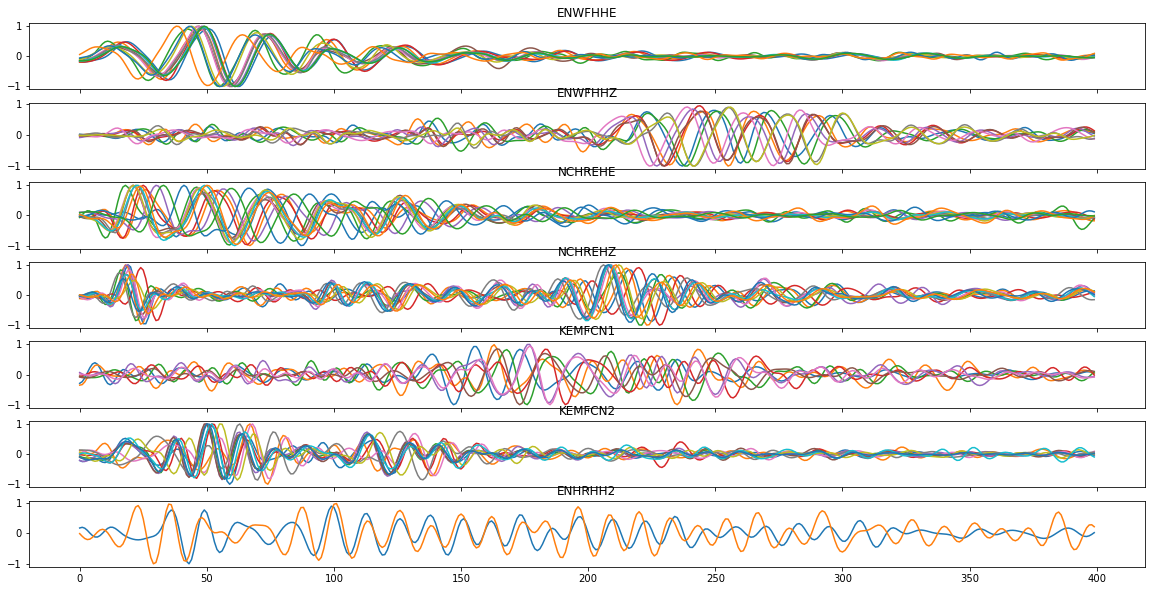

In [27]:
# Plot a given group
group = groups[5]

# Get list of channels
chan_all = []
for temp in group:
    chan_all.extend([i.stats.station + '.' + i.stats.channel for i in temp[0]])
chans = []
[chans.append(x) for x in chan_all if x not in chans]

fig, ax = plt.subplots(len(chans),sharex=True,figsize=(20,10))
for i,chn in enumerate(chans):
    chn = chn.split('.')
    for j,grp in enumerate(group):
        tr1 = grp[0].select(station=chn[0],channel=chn[1])
        if len(tr1)>0:
            ax[i].plot(tr1[0].normalize())
            ax[i].set_title(chn[0]+chn[1])

## Stack and align traces

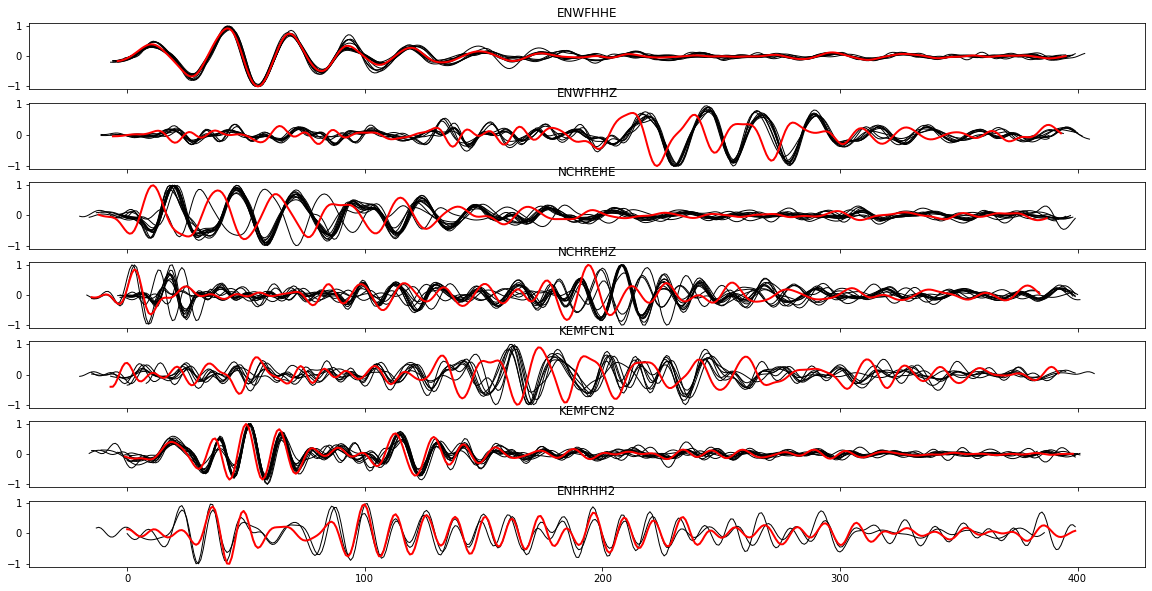

In [66]:
group = groups[5]

# Stack the group
stream_list = [ev[0] for ev in group]
stack = eqcorrscan.utils.stacking.linstack(stream_list)

# Get list of channels
chan_all = []
tr_all = obspy.core.stream.Stream()
for temp in group:
    chan_all.extend([i.stats.station + '.' + i.stats.channel for i in temp[0]])
    tr_all.extend([tr for tr in temp[0]])
chans = []
[chans.append(x) for x in chan_all if x not in chans]

fig, ax = plt.subplots(len(chans),sharex=True,figsize=(20,10))
tlen = range(len(tr_all[0].data))
for j,chn in enumerate(chans):
    chn = chn.split('.')
    filt_st = tr_all.select(station=chn[0],channel=chn[1])
    trace_list = [tr for tr in filt_st]
    # Align them
    shift_list = eqcorrscan.utils.stacking.align_traces(trace_list,20, master=False, positive=False, plot=False)
    for i,tr in enumerate(trace_list):
        ax[j].plot(tlen+(shift_list[0][i]*200),tr.normalize(),'k-',linewidth=1)
        ax[j].set_title(chn[0]+chn[1])
    # Get the stack for this channel
    chn_stack = stack.select(station=chn[0],channel=chn[1])
    # Get shift for stack
    xcor = obspy.signal.cross_correlation.correlate(chn_stack[0],trace_list[0],20)
    shift,value = obspy.signal.cross_correlation.xcorr_max(xcor)
    ax[j].plot(tlen+shift,chn_stack[0].normalize(),'r-',linewidth=2)

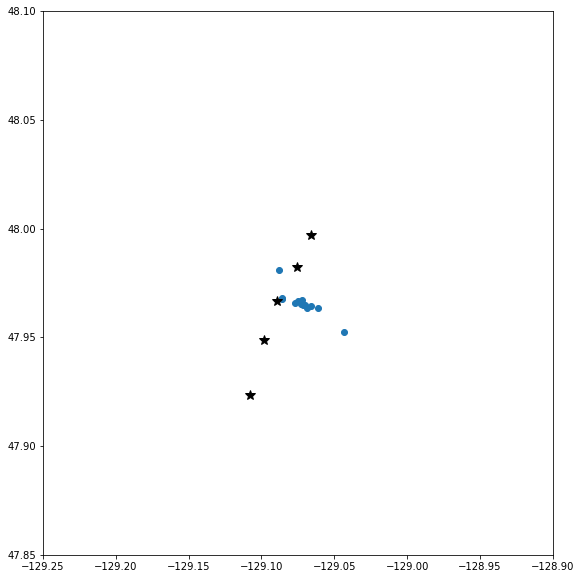

In [55]:
# How does a given group spread throughout time and space?

group_evs = []
lats = []
lons = []
depths = []
times = []
for ev in groups[5]:
    ev_id = ev[1]
    cat_ev = [c for c in cat if str(c.resource_id)[-6:]==ev_id]
    lats.append(cat_ev[0].origins[0].latitude)
    lons.append(cat_ev[0].origins[0].longitude)
    depths.append(cat_ev[0].origins[0].depth)
    times.append(cat_ev[0].origins[0].time.datetime)

    
vent_lon=[-129.098100000000,-129.089400000000,-129.075600000000,-129.108200000000,-129.066200000000]
vent_lat=[47.9487000000000,47.9666000000000,47.9822000000000,47.9233000000000,47.9969000000000] 

fig, ax = plt.subplots(1, 1,figsize=[10,10])
ax.plot(vent_lon,vent_lat,'k*',markersize=10,linestyle="none")
ax.set_xlim([-129.25,-128.9])
ax.set_ylim([47.85,48.1])
ax.set_aspect(1/0.67);
ax.scatter(lons,lats)

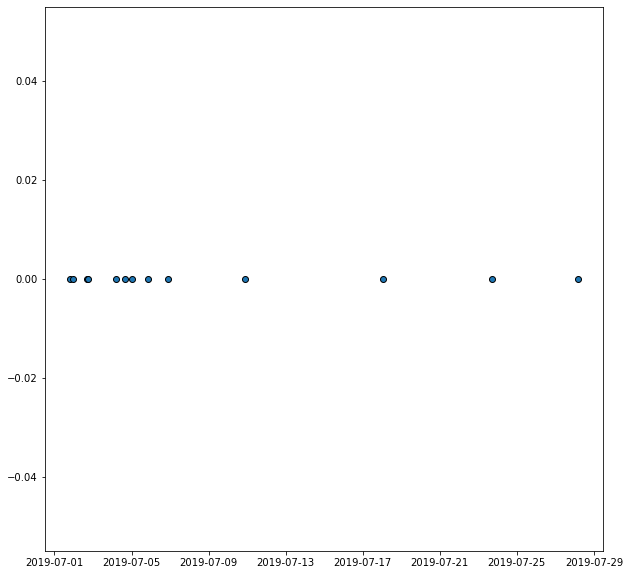

In [75]:
fig, ax = plt.subplots(1, 1,figsize=[10,10])
ax.plot(times,np.zeros(len(times)),'o',mec='k');

In [109]:
keep_list

[3, 4, 6, 7, 8, 10, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 28, 29, 30, 31, 33]

## Now filter groups to ones that only contain earthquakes less than a given distance from each other. Construct a template for each of those using the stack from that group. Then make a tribe from those stacked templates.

In [53]:
# Distances between all earthquakes in a group
keep_list = []
for k in range(len(groups)):
    g = groups[k]

    group_evs = []
    lats = []
    lons = []
    depths = []
    times = []

    for ev in g:
        ev_id = ev[1]
        cat_ev = [c for c in cat if str(c.resource_id)[-6:]==ev_id]
        lats.append(cat_ev[0].origins[0].latitude)
        lons.append(cat_ev[0].origins[0].longitude)
        depths.append(cat_ev[0].origins[0].depth)
        times.append(cat_ev[0].origins[0].time.datetime)

    dist_matr = np.zeros([len(g),len(g)])
    for i,eq1 in enumerate(g):
        for j,eq2 in enumerate(g):
            dist_matr[i,j] = geodesic((lats[i],lons[i]),(lats[j],lons[j])).meters
    #print(k)
    #print('number in group is ' + str(len(g)))
    #print('max distance is ' + str(np.max(dist_matr)))
    #print('median distance is ' + str(np.median(dist_matr)))
    
    if np.median(dist_matr)<600:
        keep_list.append(k)

In [141]:
# Filter based on distance and then stack all earthquakes in a group to create a template

# Template metadata
lowcut = 5
highcut = 20
samp_rate=200.0
filt_order=4
length=2.0
prepick=0.1
process_len=200


temp_groups = [groups[k] for k in keep_list]

stack_templates = []
for i,group in enumerate(temp_groups):
    
    # Stack the group
    stream_list = [ev[0] for ev in group]
    stack = eqcorrscan.utils.stacking.linstack(stream_list)
    
    stack_templates.append(eqcorrscan.core.match_filter.template.Template(name='tempgroup'+str(i),st=stack, lowcut=lowcut, highcut=highcut, samp_rate=samp_rate, filt_order=filt_order, process_length=process_len, prepick=prepick))

    
    

tribe = eqcorrscan.core.match_filter.tribe.Tribe(templates = stack_templates)

In [142]:
# Save them
tribe.write('filtered_templates_july2019')

Tribe of 21 templates

In [107]:
# Or read them back in
tribe = eqcorrscan.core.match_filter.tribe.read_tribe('filtered_templates_july2019.tgz')

## Use the tribe of stacked templates to perform matched-filter detection on the same month they are from, July 2019.

### The saved templates have a median distance of < 600 m

### This is really time-intensive- once I find a threshold I'm comfortable with (need to look at some output detections and verify them), I need to put this in parallel

In [101]:
tribe = eqcorrscan.core.match_filter.tribe.Tribe(templates = tribe[0])

In [114]:
%%time

client = Client('IRIS')
t1 = obspy.UTCDateTime("2019-07-01-17")
t2 = obspy.UTCDateTime("2019-07-01-18")

party,stream = tribe.client_detect(client,t1,t2,threshold=8, threshold_type='MAD',trig_int=1,return_stream=True,cores=2)

Last bit of data between 2019-07-01T17:03:17.935000Z and 2019-07-01T17:03:22.065000Z will go unused because it is shorter than a chunk of 200.0 s
Last bit of data between 2019-07-01T17:06:37.935000Z and 2019-07-01T17:06:42.065000Z will go unused because it is shorter than a chunk of 200.0 s
Last bit of data between 2019-07-01T17:09:57.935000Z and 2019-07-01T17:10:02.065000Z will go unused because it is shorter than a chunk of 200.0 s
Last bit of data between 2019-07-01T17:13:17.935000Z and 2019-07-01T17:13:22.065000Z will go unused because it is shorter than a chunk of 200.0 s
Last bit of data between 2019-07-01T17:16:37.935000Z and 2019-07-01T17:16:42.065000Z will go unused because it is shorter than a chunk of 200.0 s
Last bit of data between 2019-07-01T17:19:57.935000Z and 2019-07-01T17:20:02.065000Z will go unused because it is shorter than a chunk of 200.0 s
Last bit of data between 2019-07-01T17:23:17.935000Z and 2019-07-01T17:23:22.065000Z will go unused because it is shorter th

CPU times: user 10.1 s, sys: 1.21 s, total: 11.3 s
Wall time: 1min 15s


In [34]:
import datetime
test = datetime.datetime.now()

In [36]:
test
print(datetime.datetime.now()-test)

0:00:16.114384


## Add pick times to plots!! And then compare not visually, but see if the detections match the og catalog.

In [116]:
for p in party:
    print(p)

Family of 21 detections from template tempgroup0
Family of 0 detections from template tempgroup1
Family of 2 detections from template tempgroup2
Family of 0 detections from template tempgroup3
Family of 1 detections from template tempgroup4
Family of 0 detections from template tempgroup5
Family of 0 detections from template tempgroup6
Family of 0 detections from template tempgroup7
Family of 0 detections from template tempgroup8
Family of 2 detections from template tempgroup9
Family of 0 detections from template tempgroup10
Family of 1 detections from template tempgroup11
Family of 0 detections from template tempgroup12
Family of 0 detections from template tempgroup13
Family of 0 detections from template tempgroup14
Family of 0 detections from template tempgroup15
Family of 0 detections from template tempgroup16
Family of 0 detections from template tempgroup17
Family of 0 detections from template tempgroup18
Family of 0 detections from template tempgroup19
Family of 0 detections from t

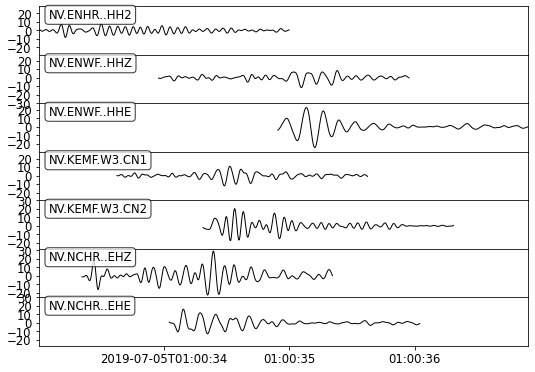

In [117]:
# Plot a template
fig = plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
tribe[2].st.plot(fig=fig);

In [129]:
party[2][0].event.picks[0].time

2019-07-01T17:17:05.670000Z

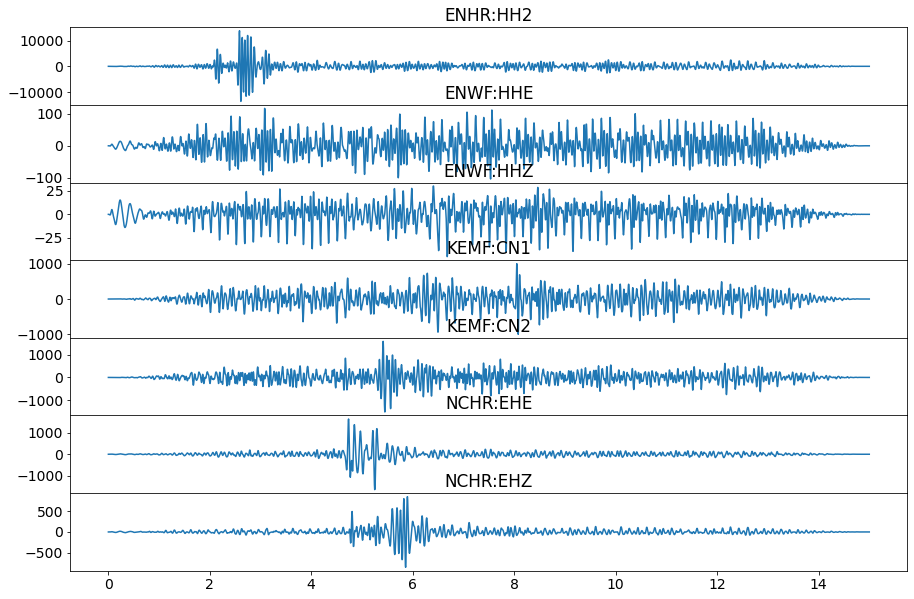

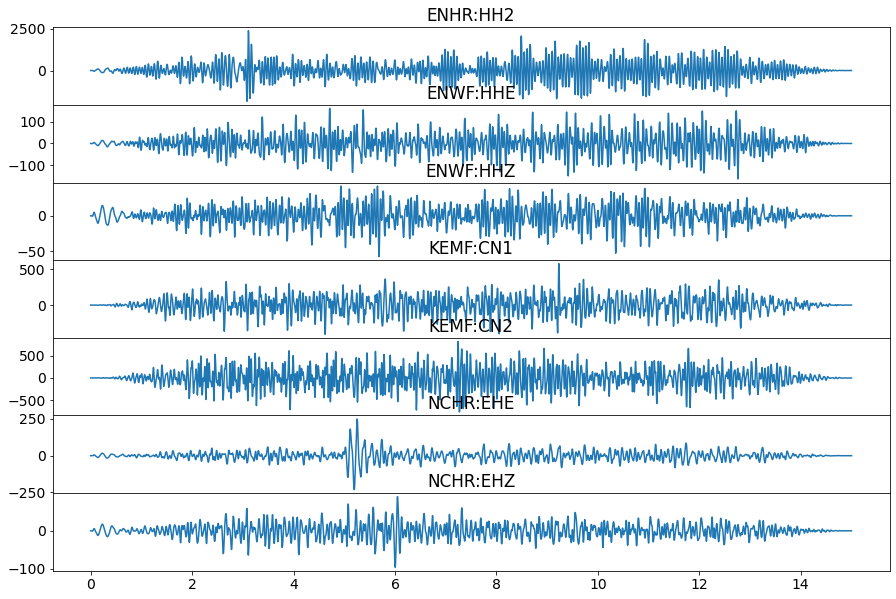

In [130]:
for ind in range(2):
    det = party[2][ind]
    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(len(det.event.picks), 1, gridspec_kw={'hspace': 0})
    for i,pick in enumerate(det.event.picks):
        t1 = pick.time-5
        t2 = pick.time+10
        st = client.get_waveforms("NV",pick.waveform_id.station_code,pick.waveform_id.location_code,pick.waveform_id.channel_code,t1,t2)
        st.filter('bandpass',freqmin=5,freqmax=20)
        st = st.taper(max_percentage=0.2)
    
        axs[i].plot(st[0].times(),st[0].data) 
        axs[i].set_title(pick.waveform_id.station_code+':'+pick.waveform_id.channel_code)
        # axs[i].vlines(x=5,ymin=min(st[0].data),ymax=max(st[0].data),colors ='r',linewidth=1)
        

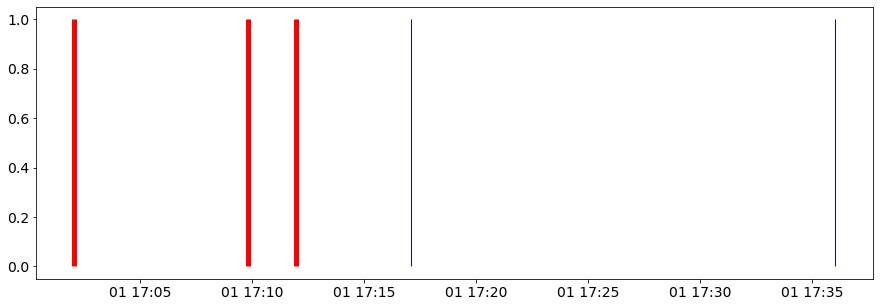

In [120]:
cat_compare =cat.filter("time > 2019-07-01T17",
                  "time < 2019-07-01T18")
auto_times = [datetime.strptime(str(c.origins[0].time),'%Y-%m-%dT%H:%M:%S.%fZ') for c in cat_compare]
xcorr_times = [p.detect_time for p in party[2]]

fig, ax = plt.subplots(1, 1,figsize=[15,5])
ax.vlines(x=auto_times,ymin=0,ymax=1,colors ='r',linewidth=5)
ax.vlines(x=xcorr_times,ymin=0,ymax=1,colors ='b',linewidth=1)
#ax.set_xlim([datetime(2019,7,1,17),datetime(2019,7,1,17,15)])

In [107]:
party[0]

Family of 13 detections from template tempgroup0

### Two questions--
1. What does the treshold value physically represent?
2. What do the pick times represent in the detections?

In [2]:
from itertools import product
l1 = [0,1,2,3]
l2 = l1
res = [ele for ele in product(l1, repeat = 2)]

In [5]:
import itertools
test = itertools.combinations(l1,2)

In [7]:
list(test)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]